<a href="https://colab.research.google.com/github/AdriPau/Prediccion-de-respuesta-al-tratamiento-de-cancer-en-piel-mediante-analisis-transcriptomicos/blob/main/Tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importe de librerías**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report

#Librerías básicas NumPy y Pandas.
import numpy as np
import pandas as pd

#Matplotlib y Seaborn - Librerías de visualización.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Ignoramos las advertencias o warnings.
import warnings
warnings.simplefilter(action='ignore')

#**2. Preprocesamiento de los datos**

## ***2.1. Carga de partición de datos y descripción inicial***

Dadas las características de los datos, fue necesario dividir todo el conjunto de datos en dos particiones para luego unidimensionalizar la información.

In [8]:
file_path = "/content/expresion_genica.xlsx"

df = pd.read_excel(file_path)

In [9]:
df.head()

,Patient,Gen,Protein Change,Gene Expression,Mutation Type
0,P1,BRAF,V600E,155.1900,Missense_Mutation
1,P1,PTEN,no alteration,1873.1000,No_Mutation
2,P1,STK11,no alteration,1059.4300,No_Mutation
3,P2,BRAF,V600E,60.0649,Missense_Mutation
4,P2,PTEN,R130*,213.6360,Nonsense_Mutation


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Patient          739 non-null    object 
 1   Gen              738 non-null    object 
 2   Protein Change   739 non-null    object 
 3   Gene Expression  735 non-null    float64
 4   Mutation Type    739 non-null    object 
dtypes: float64(1), object(4)
memory usage: 29.0+ KB


In [10]:
df.describe()

,Gene Expression
count,735.000000
mean,856.158034
std,685.951410
min,3.876000
25%,224.952000
50%,820.449000
75%,1259.295000
max,5136.130000


##***2.2. Pivot de acuerdo a expresión génica***

In [ ]:
# Pivotar los datos
df_pivot = df.pivot_table(index='Patient', columns='Gen', values=['Protein Change', 'Gene Expression', 'Protein Change'], aggfunc='first')

# Ordenar por 'Patient'
df_pivot = df_pivot.sort_values(by='Patient')
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]

df_pivot

,Gene Expression_BRAF,Gene Expression_PTEN,Gene Expression_STK11,Mutation Type_BRAF,Mutation Type_PTEN,Mutation Type_STK11,Protein Change_BRAF,Protein Change_PTEN,Protein Change_STK11
Patient,,,,,,,,,
P1,155.190,1873.100,1059.430,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration
P10,144.735,1457.240,967.784,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration
P100,103.741,181.546,1237.640,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration
P101,105.359,414.169,1249.880,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration
P102,186.484,1430.280,1332.430,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration
...,...,...,...,...,...,...,...,...,...
P95,279.541,1987.310,503.130,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration
P96,413.370,939.478,727.662,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration
P97,302.224,1722.520,849.288,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration


##***2.3. Carga de segunda partición de datos***

In [ ]:
file_path_2 = "/content/Datos_clinicos.xlsx"

df_resto = pd.read_excel(file_path_2, index_col="Patient")

In [ ]:
df_resto

,Diagnosis Age,Disease Stage,Ethnicity Category,Fraction Genome Altered,Radiation Therapy,Sex,Overall Survival Status
Patient,,,,,,,
P1,50.0,STAGE III,Not Hispanic Or Latino,0.5160,No,Male,1.0
P2,46.0,STAGE IIC,NaN,0.6825,No,Female,0.0
P3,56.0,STAGE I,Not Hispanic Or Latino,0.7403,No,Male,1.0
P4,63.0,STAGE IIA,Not Hispanic Or Latino,0.4651,No,Male,1.0
P5,28.0,STAGE IB,Not Hispanic Or Latino,0.2333,No,Female,1.0
...,...,...,...,...,...,...,...
P241,73.0,STAGE IIC,Not Hispanic Or Latino,0.1650,No,Female,1.0
P242,52.0,STAGE II,Not Hispanic Or Latino,0.2798,No,Male,1.0
P243,85.0,STAGE IIIC,Not Hispanic Or Latino,0.3269,No,Male,1.0


In [ ]:
df_resto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, P1 to P245
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Diagnosis Age            241 non-null    float64
 1   Disease Stage            224 non-null    object 
 2   Ethnicity Category       239 non-null    object 
 3   Fraction Genome Altered  245 non-null    float64
 4   Radiation Therapy        242 non-null    object 
 5   Sex                      245 non-null    object 
 6   Overall Survival Status  241 non-null    float64
dtypes: float64(3), object(4)
memory usage: 15.3+ KB


In [ ]:
df_resto.describe()

,Diagnosis Age,Fraction Genome Altered,Overall Survival Status
count,241.000000,245.000000,241.000000
mean,54.975104,0.325171,0.464730
std,16.313830,0.199304,0.499792
min,15.000000,0.000100,0.000000
25%,44.000000,0.192300,0.000000
50%,56.000000,0.288900,0.000000
75%,68.000000,0.463100,1.000000
max,87.000000,0.968300,1.000000


##***2.4. Unión de particiones***

In [ ]:
df_merged = pd.merge(df_pivot, df_resto, on='Patient', how='outer')

In [ ]:
df_merged

,Gene Expression_BRAF,Gene Expression_PTEN,Gene Expression_STK11,Mutation Type_BRAF,Mutation Type_PTEN,Mutation Type_STK11,Protein Change_BRAF,Protein Change_PTEN,Protein Change_STK11,Diagnosis Age,Disease Stage,Ethnicity Category,Fraction Genome Altered,Radiation Therapy,Sex,Overall Survival Status
Patient,,,,,,,,,,,,,,,,
P1,155.190,1873.100,1059.430,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,50.0,STAGE III,Not Hispanic Or Latino,0.5160,No,Male,1.0
P10,144.735,1457.240,967.784,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,24.0,NaN,Not Hispanic Or Latino,0.2729,No,Female,0.0
P100,103.741,181.546,1237.640,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,58.0,STAGE IV,Not Hispanic Or Latino,0.3817,No,Male,0.0
P101,105.359,414.169,1249.880,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,75.0,STAGE IIIA,Not Hispanic Or Latino,0.3797,No,Female,0.0
P102,186.484,1430.280,1332.430,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,56.0,NaN,Not Hispanic Or Latino,0.7953,No,Male,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P95,279.541,1987.310,503.130,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,37.0,STAGE IIIB,Not Hispanic Or Latino,0.6137,No,Female,0.0
P96,413.370,939.478,727.662,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,45.0,STAGE I,Not Hispanic Or Latino,0.4247,No,Male,1.0
P97,302.224,1722.520,849.288,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,37.0,NaN,Not Hispanic Or Latino,0.2918,No,Female,1.0


In [ ]:
#Exportar el dataframe con datos crudos
file_path = "df_crude.xlsx"  # Cambia este nombre por el que desees
df_merged.to_excel(file_path, index=False)

##***2.5. Tratamiento de valores NaN***

Para completar las features se aplicó los valores medios en columnas numéricas y la moda en columnas categóricas.

In [ ]:
#Completar NaN

df_merged["Gene Expression_BRAF"] = df_merged["Gene Expression_BRAF"].fillna(df_merged["Gene Expression_BRAF"].mean())
df_merged["Gene Expression_PTEN"] = df_merged["Gene Expression_PTEN"].fillna(df_merged["Gene Expression_PTEN"].mean())
df_merged["Gene Expression_STK11"] = df_merged["Gene Expression_STK11"].fillna(df_merged["Gene Expression_STK11"].mean())
df_merged["Mutation Type_BRAF"] = df_merged["Mutation Type_BRAF"].fillna(df_merged["Mutation Type_BRAF"].mode()[0])
df_merged["Mutation Type_PTEN"] = df_merged["Mutation Type_PTEN"].fillna(df_merged["Mutation Type_PTEN"].mode()[0])
df_merged["Mutation Type_STK11"] = df_merged["Mutation Type_STK11"].fillna(df_merged["Mutation Type_STK11"].mode()[0])
df_merged["Protein Change_BRAF"] = df_merged["Protein Change_BRAF"].fillna(df_merged["Protein Change_BRAF"].mode()[0])
df_merged["Protein Change_PTEN"] = df_merged["Protein Change_PTEN"].fillna(df_merged["Protein Change_PTEN"].mode()[0])
df_merged["Protein Change_STK11"] = df_merged["Protein Change_STK11"].fillna(df_merged["Protein Change_STK11"].mode()[0])
df_merged["Diagnosis Age"] = df_merged["Diagnosis Age"].fillna(df_merged["Diagnosis Age"].mean())
df_merged["Disease Stage"] = df_merged["Disease Stage"].fillna(df_merged["Disease Stage"].mode()[0])
df_merged["Ethnicity Category"] = df_merged["Ethnicity Category"].fillna(df_merged["Ethnicity Category"].mode()[0])
df_merged["Radiation Therapy"] = df_merged["Radiation Therapy"].fillna(df_merged["Radiation Therapy"].mode()[0])
df_merged["Fraction Genome Altered"] = df_merged["Fraction Genome Altered"].fillna(df_merged["Fraction Genome Altered"].mean())
df_merged["Sex"] = df_merged["Sex"].fillna(df_merged["Sex"].mode()[0])
df_merged["Overall Survival Status"] = df_merged["Overall Survival Status"].fillna(df_merged["Overall Survival Status"].mode()[0])

Comprobación de valores nulos posterior a el tratamiento.

In [ ]:
print(df_merged.isna().sum())

Gene Expression_BRAF       0
Gene Expression_PTEN       0
Gene Expression_STK11      0
Mutation Type_BRAF         0
Mutation Type_PTEN         0
Mutation Type_STK11        0
Protein Change_BRAF        0
Protein Change_PTEN        0
Protein Change_STK11       0
Diagnosis Age              0
Disease Stage              0
Ethnicity Category         0
Fraction Genome Altered    0
Radiation Therapy          0
Sex                        0
Overall Survival Status    0
dtype: int64


##***2.6. Partición del dataframe***

El dataframe se particionó de acuerdo al tipo de datos que posee. Numéricos y categóricos.

In [ ]:
#Dataframe con datos categóricos
df_categorical = df_merged.select_dtypes(include=['object'])
df_categorical

,Mutation Type_BRAF,Mutation Type_PTEN,Mutation Type_STK11,Protein Change_BRAF,Protein Change_PTEN,Protein Change_STK11,Disease Stage,Ethnicity Category,Radiation Therapy,Sex
Patient,,,,,,,,,,
P1,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,STAGE III,Not Hispanic Or Latino,No,Male
P10,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,STAGE IIC,Not Hispanic Or Latino,No,Female
P100,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,STAGE IV,Not Hispanic Or Latino,No,Male
P101,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,STAGE IIIA,Not Hispanic Or Latino,No,Female
P102,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,STAGE IIC,Not Hispanic Or Latino,No,Male
...,...,...,...,...,...,...,...,...,...,...
P95,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,STAGE IIIB,Not Hispanic Or Latino,No,Female
P96,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,STAGE I,Not Hispanic Or Latino,No,Male
P97,Missense_Mutation,No_Mutation,No_Mutation,V600E,no alteration,no alteration,STAGE IIC,Not Hispanic Or Latino,No,Female


In [ ]:
#Dataframe con datos numéricos
df_numerical = df_merged.select_dtypes(include=['number'])
df_numerical.drop(columns=["Overall Survival Status"], inplace=True)
df_numerical

,Gene Expression_BRAF,Gene Expression_PTEN,Gene Expression_STK11,Diagnosis Age,Fraction Genome Altered
Patient,,,,,
P1,155.190,1873.100,1059.430,50.0,0.5160
P10,144.735,1457.240,967.784,24.0,0.2729
P100,103.741,181.546,1237.640,58.0,0.3817
P101,105.359,414.169,1249.880,75.0,0.3797
P102,186.484,1430.280,1332.430,56.0,0.7953
...,...,...,...,...,...
P95,279.541,1987.310,503.130,37.0,0.6137
P96,413.370,939.478,727.662,45.0,0.4247
P97,302.224,1722.520,849.288,37.0,0.2918


##***2.7. Transformación de datos categóricos***

Dado que las features categóricas tienen mas de 2 categorías se procedió a aplicar una transformación `OneHotEncoder`.

In [ ]:
#Transformación de categóricos

# Crear el objeto OneHotEncoder
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)

# Ajustar y transformar los datos (solo para las columnas categóricas)
encoder_data = encoder.fit_transform(df_categorical)

# Crear un DataFrame con los datos transformados
df_encoded = pd.DataFrame(encoder_data, columns=encoder.get_feature_names_out(df_categorical.columns))

In [ ]:
df_encoded

,Mutation Type_BRAF_In_Frame_Del,Mutation Type_BRAF_Missense_Mutation,Mutation Type_BRAF_No_Mutation,Mutation Type_BRAF_Splice_Site,Mutation Type_BRAF_fusion,Mutation Type_PTEN_Frame_Shift_Del,Mutation Type_PTEN_Frame_Shift_Ins,Mutation Type_PTEN_In_Frame_Ins,Mutation Type_PTEN_Missense_Mutation,Mutation Type_PTEN_No_Mutation,...,Disease Stage_STAGE IIB,Disease Stage_STAGE IIC,Disease Stage_STAGE III,Disease Stage_STAGE IIIA,Disease Stage_STAGE IIIB,Disease Stage_STAGE IIIC,Disease Stage_STAGE IV,Ethnicity Category_Not Hispanic Or Latino,Radiation Therapy_Yes,Sex_Male
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
243,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
244,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
245,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##***2.8. Transformación de datos numéricos***

Para los modelos de ML que se van a aplicar se realizarán dos transformaciones a los datos numéricos.

- `StandardScaler`: transforma las variables numéricas a media cero y desviación estándar 1 (distribución normal).
- `MinMaxScaler`: transforma las variables numéricas como máximo 1 y mínimo 0 (distribución uniforme).

In [ ]:
#Transformación variables numéricos
# Crear el objeto StandardScaler
scaler_1 = StandardScaler()

# Escalar las columnas numéricas
normalized_data = scaler_1.fit_transform(df_numerical)
df_normalized = pd.DataFrame(normalized_data, columns=df_numerical.columns)
df_normalized

,Gene Expression_BRAF,Gene Expression_PTEN,Gene Expression_STK11,Diagnosis Age,Fraction Genome Altered
0,-0.408013,0.804780,-0.146827,-0.309378,0.963345
1,-0.513534,0.259832,-0.386796,-1.926193,-0.263875
2,-0.927282,-1.411851,0.319805,0.188104,0.285370
3,-0.910952,-1.107019,0.351855,1.245252,0.275274
4,-0.092167,0.224504,0.568006,0.063733,2.373311
...,...,...,...,...,...
242,0.847047,0.954442,-1.603463,-1.117785,1.456556
243,2.197767,-0.418649,-1.015540,-0.620304,0.502443
244,1.075984,0.607458,-0.697070,-1.117785,-0.168464
245,0.543201,0.796550,-1.236484,1.618363,-0.875214


In [ ]:
#Transformación normalizada
# Crear el objeto MinMaxScaler
scaler_2 = MinMaxScaler()

# Normalizar las columnas numéricas
scaled_data = scaler_2.fit_transform(df_numerical)

# Convertir la matriz normalizada a un DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df_numerical.columns)
df_scaled

,Gene Expression_BRAF,Gene Expression_PTEN,Gene Expression_STK11,Diagnosis Age,Fraction Genome Altered
0,0.225981,0.363148,0.365309,0.486111,0.532844
1,0.210367,0.281984,0.325988,0.125000,0.281760
2,0.149144,0.033004,0.441772,0.597222,0.394133
3,0.151560,0.078405,0.447023,0.833333,0.392068
4,0.272717,0.276722,0.482442,0.569444,0.821318
...,...,...,...,...,...
242,0.411693,0.385438,0.126625,0.305556,0.633753
243,0.611561,0.180931,0.222962,0.416667,0.438546
244,0.445570,0.333759,0.275147,0.305556,0.301281
245,0.366733,0.361922,0.186758,0.916667,0.156683


#**3. Modelos de Machine Learning**

## **3.1. Modelo KNN**

Para este modelo se sugiere utilizar el dataframe con los datos numéricos transformados con `MinMaxScaler`. Dado que el modelo utiliza distancias para ejecutar el algoritmo.

In [ ]:
# Función para visualizar la curva de aprendizaje a partir
# del error de entrenamiento y de generalización.
def plot_learning_curve(train_error, generalization_error):

  balance_point = np.array(generalization_error).argmin() + 1
  plt.figure(figsize = (8, 5), dpi = 105)

  plt.plot(range(1, k_values + 1), train_error, label="Entrenamiento")
  plt.plot(range(1, k_values + 1), generalization_error, label="Validación")
  plt.xticks(range(0, k_values + 1, 5))
  plt.xlabel("k-vecinos")
  plt.ylabel("Error")
  y_min, y_max = plt.gca().get_ylim()
  plt.vlines(balance_point, y_min, y_max, colors = ['red'], linestyles = ['dashdot'])
  plt.ylim([y_min, y_max])
  plt.text(balance_point + 1, 0.165, 'Punto de balance')
  plt.legend();

###***3.1.1. Creación de particiones de entrenamiento y validación***

In [ ]:
#Dataframe conjunto de valores numéricos y categóricos transformados
df_knn = pd.concat([df_scaled, df_encoded], axis=1)
df_knn

y = df_merged["Overall Survival Status"]
X_knn = df_knn

In [ ]:
print(X_knn.shape, y.shape)

(247, 127) (247,)


In [ ]:
y.value_counts()

,count
Overall Survival Status,
0.0,135
1.0,112


In [ ]:
# División en train y test
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size = 0.2, stratify=y, random_state = 777) # stratify, porque y esta desbalanceado (54.6% muertos y 45.4% vivos) estratifica para que las porciones de test y train sean proporcionales.

print(X_train_knn.shape , y_train_knn.shape)
print(X_test_knn.shape , y_test_knn.shape)

(197, 127) (197,)
(50, 127) (50,)


###***3.1.2. Aplicación del algorítmo KNN***

#### **Número de vecinos óptimo**

In [ ]:
k_values = 50

In [ ]:
train_error = []
generalization_error = []

for nn in range(1, k_values + 1):
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(X_train_knn, y_train_knn)
    train_error.append(1 - knn.score(X_train_knn, y_train_knn))
    generalization_error.append(1 - knn.score(X_test_knn, y_test_knn))

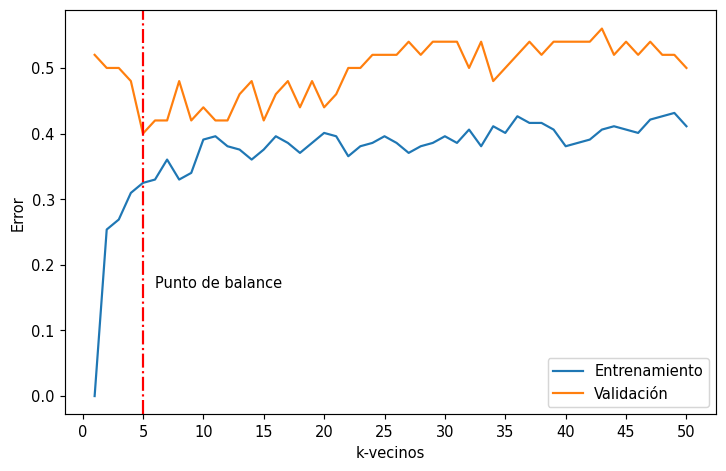

In [ ]:
plot_learning_curve(train_error, generalization_error)

In [ ]:
print(f"Error de generalización con k = 5: {generalization_error[4]} \nError de entrenamiento con k = 5: {train_error[4]}")

Error de generalización con k = 5: 0.4 
Error de entrenamiento con k = 5: 0.3248730964467005


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)

KNeighborsClassifier()

In [ ]:
# Predecir con training para analizar overfitting
yHat_train_knn = knn.predict(X_train_knn)
# Evaluar desempeño algortimo al prededir con test
yHat_test_knn = knn.predict(X_test_knn)

#### *Exactitud*

Se evaluó con datos de training para evaluar el sobreajuste y con datos de test para evaluar el desempeño.

In [ ]:
#Análisis Overfitting (para datos de training)
print('Exactitud (Accuracy):', metrics.accuracy_score(y_train_knn, yHat_train_knn))

Exactitud (Accuracy): 0.6751269035532995


In [ ]:
#Análisis con test (para datos de test)
print('Exactitud (Accuracy):', metrics.accuracy_score(y_test_knn, yHat_test_knn))

Exactitud (Accuracy): 0.6



#### *Precisión*

Se evaluó solo con datos de test para determinar el desempeño.

In [ ]:
print(f'Precisión: {metrics.precision_score(y_test_knn, yHat_test_knn, pos_label=0)}')
print(f'Recall:    {metrics.recall_score(y_test_knn, yHat_test_knn, pos_label=0)}')
print(f'F_1 score: {metrics.f1_score(y_test_knn, yHat_test_knn, pos_label=0)}')

Precisión: 0.6296296296296297
Recall:    0.6296296296296297
F_1 score: 0.6296296296296297


In [ ]:
# Calcular métricas detalladas
report = classification_report(y_test_knn, yHat_test_knn, target_names=['Clase 0', 'Clase 1'])
print("Reporte de clasificación:")
print(report)

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.63      0.63      0.63        27
     Clase 1       0.57      0.57      0.57        23

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.60      0.60      0.60        50



#### *Matriz de Confusión*

Text(0.5, 25.722222222222214, 'yHat')

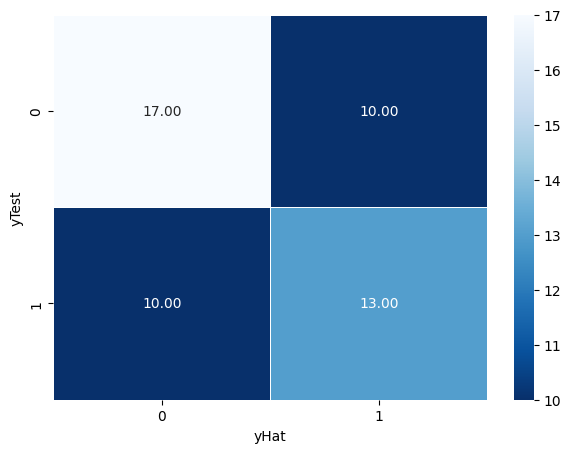

In [ ]:
# Matriz de Confusión
matriz_confusion = metrics.confusion_matrix(y_test_knn, yHat_test_knn)

# Graficar la matriz de Confusión
plt.figure(figsize=(7, 5))
plot_matriz = sns.heatmap(matriz_confusion, annot = True, fmt = '.2f', linewidths = 0.5, cmap = 'Blues_r')
plt.ylabel('yTest')
plt.xlabel('yHat')

####*Métricas ROC-AUC*

In [ ]:
# Cálculo de FPR, Recall(TPR) y puntos de corte:
scores = knn.predict_proba(X_test_knn)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_knn, scores)

# Calculo métrica ROC-AUC
aucROC = metrics.auc(fpr, tpr)
print(aucROC)

0.5668276972624798


Text(0.5, 1.0, 'Curva ROC')

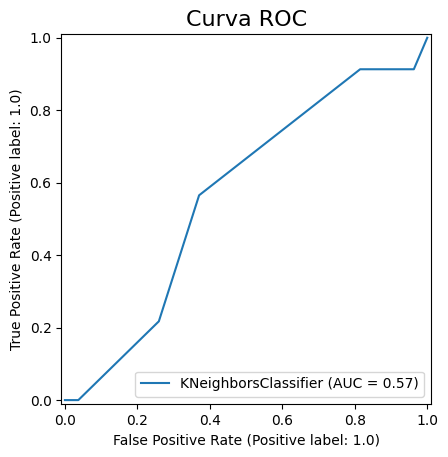

In [ ]:
# Graficar la curva ROC
curva_roc = metrics.RocCurveDisplay.from_estimator(knn, X_test_knn, y_test_knn)
plt.title('Curva ROC', fontsize=16)

## **3.2. Modelo logístico**

Para este modelo se sugiere utilizar el dataframe con los datos numéricos transformados con `StandardScaler` que se sugiere ser el más óptimo para el algoritmo.

###***3.2.1. Creación de particiones de entrenamiento y validación***

In [ ]:
#Dataframe conjunto de valores numéricos y categóricos transformados
df_logmodel = pd.concat([df_normalized, df_encoded], axis=1)
df_logmodel

X_log = df_logmodel

In [ ]:
# División en train y test
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y, test_size = 0.2, stratify=y, random_state = 777) # stratify, porque y esta desbalanceado (54.6% muertos y 45.4% vivos) estratifica para que las porciones de test y train sean proporcionales.

print(X_train_log.shape , y_train_log.shape)

(197, 127) (197,)


###***3.2.2. Aplicación del algorítmo reg-logística***

In [ ]:
#Declaramos el algoritmo
reg_logistica = LogisticRegression(C=1,
                                   multi_class = 'auto',
                                   class_weight='balanced', # Balanceamos las categorias debido a que poseen desbalance
                                   random_state=777,
                                   n_jobs=-1) # Se emplean todos los nucleos disponibles para el calculo

reg_logistica

LogisticRegression(C=1, class_weight='balanced', multi_class='auto', n_jobs=-1,
                   random_state=777)

In [ ]:
#Ajuste del logaritmo
reg_logistica.fit(X_train_log, y_train_log)

LogisticRegression(C=1, class_weight='balanced', multi_class='auto', n_jobs=-1,
                   random_state=777)

In [ ]:
print('Intercepto', reg_logistica.intercept_)
print('Pendientes', reg_logistica.coef_.round(4))

Intercepto [0.73769378]
Pendientes [[ 0.1735 -0.18   -0.0361  0.0096 -0.112  -0.0296 -0.6063  0.1335  0.2296
   0.2696 -0.0035 -0.66    0.2859  0.0066 -0.0856  0.1662  0.2789  0.0083
   0.377  -0.2728 -0.357   0.2496  0.5192 -0.5627 -0.2669  0.3132  0.2807
  -0.2524 -0.2098 -0.3378 -0.4579  0.     -0.3997  0.     -0.2824 -0.1787
  -0.2521 -0.4477  0.4392  0.199  -0.4183  0.3415 -0.2446  0.7394 -0.3411
  -0.301  -0.1849  0.3472  0.4511  1.0323  0.      0.1605 -0.1306 -0.2579
  -0.3711  0.2296  0.6248  0.217  -0.2824  0.     -0.1846 -0.6554  0.3744
  -0.3876  0.     -0.37   -0.2959  0.199  -0.2669  0.3472  0.      0.3132
   0.2993 -0.301   0.1558 -0.2469  0.3064  0.     -0.0668  0.332   0.2807
  -0.2854  0.4547  0.      0.2435  0.0271  0.2859 -0.2014  0.      0.2789
   0.249  -0.2407 -0.4477  0.2953 -0.1271  0.     -0.0856 -0.3852  0.3597
  -0.323   0.      0.     -0.2844 -0.5783  0.377   0.3415  0.2751  0.3456
  -0.3525  0.2213 -0.4568  0.2543 -0.1453 -0.2556  0.002   0.4157  0.1743
  -

In [ ]:
# Predecir con training para analizar overfitting
yHat_train_log = reg_logistica.predict(X_train_log)
# Evaluar desempeño algortimo al prededir con test
yHat_test_log = reg_logistica.predict(X_test_log)

### **3.2.3. Métricas de desempeño**

#### *Exactitud*

In [ ]:
#Análisis Overfitting (para datos de training)
print('Exactitud (Accuracy):', metrics.accuracy_score(y_train_log, yHat_train_log))

Exactitud (Accuracy): 0.7055837563451777


In [ ]:
#Métrica de evaluación desempeño algoritmo (con los datos de test)
print('Exactitud (Accuracy):', metrics.accuracy_score(y_test_log, yHat_test_log))

Exactitud (Accuracy): 0.62


In [ ]:
reg_logistica.score(X_test_log, y_test_log)

0.62

#### *Precisión*

In [ ]:
print(f'Precisión: {metrics.precision_score(y_test_log, yHat_test_log, pos_label=0)}')
print(f'Recall:    {metrics.recall_score(y_test_log, yHat_test_log, pos_label=0)}')
print(f'F_1 score: {metrics.f1_score(y_test_log, yHat_test_log, pos_label=0)}')

Precisión: 0.625
Recall:    0.7407407407407407
F_1 score: 0.6779661016949152


In [ ]:
# Calcular métricas detalladas
report = classification_report(y_test_log, yHat_test_log, target_names=['Clase 0', 'Clase 1'])
print("Reporte de clasificación:")
print(report)

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.62      0.74      0.68        27
     Clase 1       0.61      0.48      0.54        23

    accuracy                           0.62        50
   macro avg       0.62      0.61      0.61        50
weighted avg       0.62      0.62      0.61        50



####*Matriz de Confusión*

Text(0.5, 25.722222222222214, 'yHat')

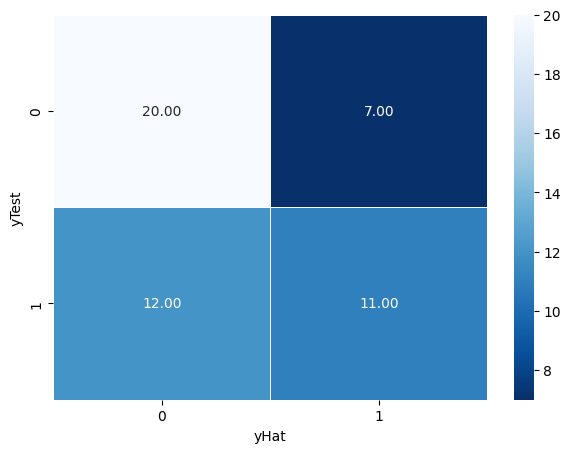

In [ ]:
# Matriz de Confusión
matriz_confusion = metrics.confusion_matrix(y_test_log, yHat_test_log)

# Graficar la matriz de Confusión
plt.figure(figsize=(7, 5))
plot_matriz = sns.heatmap(matriz_confusion, annot = True, fmt = '.2f', linewidths = 0.5, cmap = 'Blues_r')
plt.ylabel('yTest')
plt.xlabel('yHat')

####*Métricas ROC-AUC*

In [ ]:
# Cálculo de FPR, Recall(TPR) y puntos de corte:
scores = reg_logistica.predict_proba(X_test_log)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_log, scores)

# Calculo métrica ROC-AUC
aucROC = metrics.auc(fpr, tpr)
print(aucROC)

0.5636070853462157


Text(0.5, 1.0, 'Curva ROC')

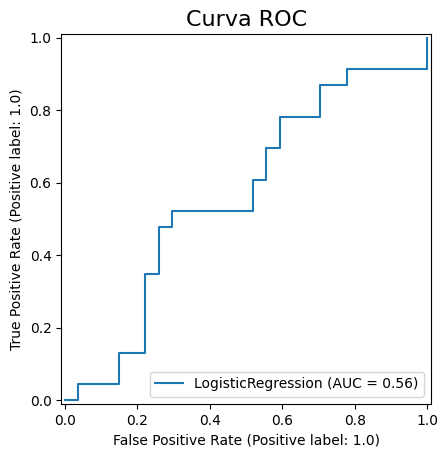

In [ ]:
# Graficar la curva ROC
curva_roc = metrics.RocCurveDisplay.from_estimator(reg_logistica, X_test_log, y_test_log)
plt.title('Curva ROC', fontsize=16)

### **3.2.4. Optimización del modelo logístico**

Para optimizar el modelo logístico se utilizó `GridSerchCV` a fin de encontrar la combinación de hiperparámetros mas óptima.

In [ ]:
from sklearn.model_selection import GridSearchCV
# Definir el modelo base
model = LogisticRegression(max_iter=1000)

# Definir el espacio de hiperparámetros
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'class_weight': [None, 'balanced'],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  # Cambiar a otra métrica si es necesario
    cv=5,                # Número de folds en la validación cruzada
    verbose=0,           # Para imprimir el progreso
    n_jobs=-1            # Usar todos los núcleos disponibles
)

# Ajustar el modelo con el Grid Search
grid_search.fit(X_train_log, y_train_log)

# Mejor modelo
best_model = grid_search.best_estimator_

In [ ]:
# Mostrar los mejores parámetros
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)

Mejores hiperparámetros encontrados: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}


In [ ]:
#Declaramos el algoritmo
reg_logistica_opt = LogisticRegression(C=0.01,
                                       multi_class = 'auto',
                                       class_weight = None, # Balanceamos las categorias debido a que poseen desbalance
                                       penalty = 'l2',
                                       solver = 'liblinear',
                                       tol = 0.0001,
                                       random_state=777,
                                       n_jobs=-1) # Se emplean todos los nucleos disponibles para el calculo

#Ajuste del logaritmo
reg_logistica_opt.fit(X_train_log, y_train_log)

LogisticRegression(C=0.01, multi_class='auto', n_jobs=-1, random_state=777,
                   solver='liblinear')

In [ ]:
# Predecir con training para analizar overfitting
yHat_train_logopt = reg_logistica_opt.predict(X_train_log)
# Evaluar desempeño algortimo al prededir con test
yHat_test_logopt = reg_logistica_opt.predict(X_test_log)

#### *Exactitud*

In [ ]:
#Análisis Overfitting (para datos de training)
print('Exactitud (Accuracy):', metrics.accuracy_score(y_train_log, yHat_train_logopt))

Exactitud (Accuracy): 0.5736040609137056


In [ ]:
#Métrica de evaluación desempeño algoritmo (con los datos de test)
print('Exactitud (Accuracy):', metrics.accuracy_score(y_test_log, yHat_test_logopt))

Exactitud (Accuracy): 0.52


####*Precisión*

In [ ]:
print(f'Precisión: {metrics.precision_score(y_test_log, yHat_test_logopt, pos_label=0)}')
print(f'Recall:    {metrics.recall_score(y_test_log, yHat_test_logopt, pos_label=0)}')
print(f'F_1 score: {metrics.f1_score(y_test_log, yHat_test_logopt, pos_label=0)}')

Precisión: 0.5306122448979592
Recall:    0.9629629629629629
F_1 score: 0.6842105263157895


In [ ]:
# Calcular métricas detalladas
report = classification_report(y_test_log, yHat_test_logopt, target_names=['Clase 0', 'Clase 1'])
print("Reporte de clasificación:")
print(report)

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.53      0.96      0.68        27
     Clase 1       0.00      0.00      0.00        23

    accuracy                           0.52        50
   macro avg       0.27      0.48      0.34        50
weighted avg       0.29      0.52      0.37        50



#### *Matriz de Confusión*

Text(0.5, 25.722222222222214, 'yHat')

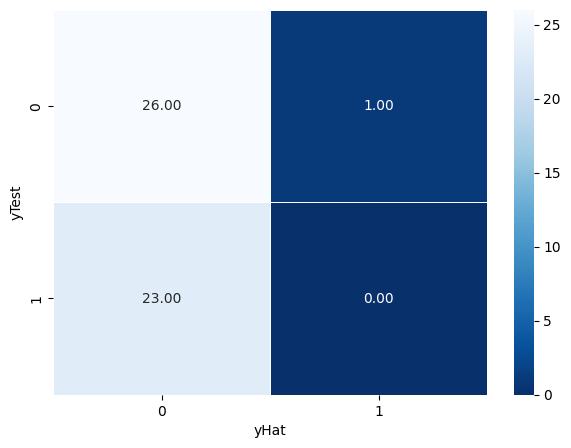

In [ ]:
# Matriz de Confusion
matriz_confusion = metrics.confusion_matrix(y_test_log, yHat_test_logopt)

# Graficar la matriz de Confusion
plt.figure(figsize=(7, 5))
plot_matriz = sns.heatmap(matriz_confusion, annot = True, fmt = '.2f', linewidths = 0.5, cmap = 'Blues_r')
plt.ylabel('yTest')
plt.xlabel('yHat')

####*Métricas ROC-AUC*

In [ ]:
# Cálculo de FPR, Recall(TPR) y puntos de corte:
scores = reg_logistica_opt.predict_proba(X_test_log)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_log, scores)

# Calculo métrica ROC-AUC
aucROC = metrics.auc(fpr, tpr)
print(aucROC)

0.5845410628019324


Text(0.5, 1.0, 'Curva ROC')

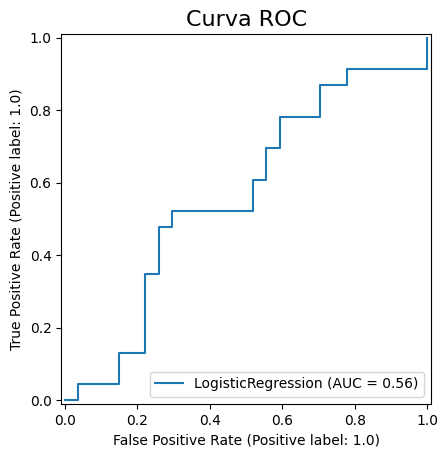

In [ ]:
# Graficar la curva ROC
curva_roc = metrics.RocCurveDisplay.from_estimator(reg_logistica, X_test_log, y_test_log)
plt.title('Curva ROC', fontsize=16)

#**4. Red Neuronal**

Para aplicar la red neuronal vamos a hacer uso de tensorflow.

##**4.1. Importe de librerías**

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

##**4.2. Creación de particiones de entrenamiento y validación**

In [ ]:
#Dataframe conjunto de valores numéricos y categóricos transformados
df_red = pd.concat([df_normalized, df_encoded], axis=1)

X_red = df_red

In [ ]:
# Dividir en conjunto de entrenamiento y prueba
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y, test_size=0.2, random_state=777)

##**4.3. Construcción del modelo de la red neuronal**

In [ ]:
# Crear el modelo
model = Sequential()

# Capa de entrada + capa oculta (ejemplo con 64 neuronas y activación ReLU)
model.add(Dense(122, activation='relu', input_dim=X_train_red.shape[1]))

# Otra capa oculta (opcional)
model.add(Dense(32, activation='relu'))

# Otra capa oculta (opcional)
model.add(Dense(32, activation='tanh'))

# Capa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

##**4.4. Entrenamiento del modelo**

In [ ]:
# Entrenar el modelo
history = model.fit(X_train_red, y_train_red,
                    validation_data=(X_test_red, y_test_red),
                    epochs=50,  # Número de épocas (ajustar según sea necesario)
                    batch_size=16,  # Tamaño del batch (ajustar según sea necesario)
                    verbose=1)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5196 - loss: 0.7068 - val_accuracy: 0.5600 - val_loss: 0.6877
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5533 - loss: 0.6816 - val_accuracy: 0.5600 - val_loss: 0.6972
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6203 - loss: 0.6399 - val_accuracy: 0.5600 - val_loss: 0.6972
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6563 - loss: 0.6224 - val_accuracy: 0.5000 - val_loss: 0.7103
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7675 - loss: 0.5975 - val_accuracy: 0.5200 - val_loss: 0.7086
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7525 - loss: 0.5564 - val_accuracy: 0.4600 - val_loss: 0.7291
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7769 - loss: 0.5508 - val_accuracy: 0.6000 - val_loss: 0.7172
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7485 - loss: 0.5402 - val_accuracy: 0.5400 - val

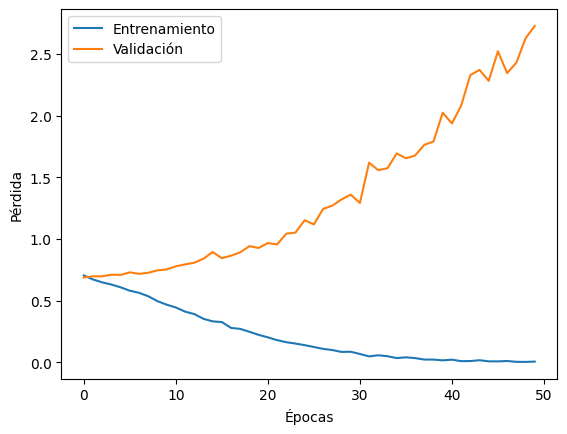

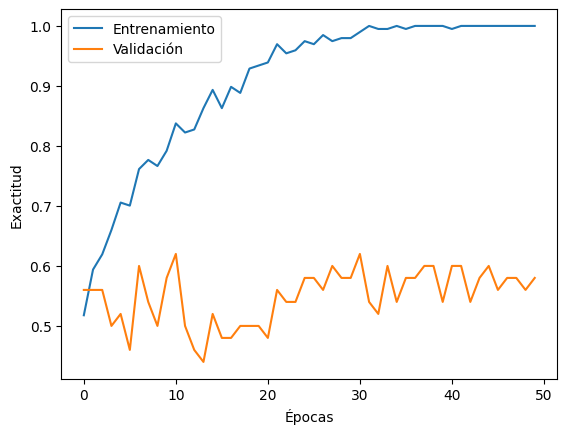

In [ ]:
# Gráfica de la pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Gráfica de la precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()
plt.show()

##**4.5. Evaluación del modelo**

In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_red, y_test_red)
print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Exactitud en el conjunto de prueba: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5846 - loss: 2.7641 
Pérdida en el conjunto de prueba: 2.7260313034057617
Exactitud en el conjunto de prueba: 0.5799999833106995


###***Exactitud***

In [ ]:
# Predecir con training para analizar overfitting
yHat_train_prob = model.predict(X_train_red)
# Convertir a etiquetas (0 o 1)
yHat_train_red = (yHat_train_prob > 0.5).astype(int)
# Evaluar desempeño algortimo al prededir con test
yHat_test_prob = model.predict(X_test_red)
# Convertir a etiquetas (0 o 1)
yHat_test_red = (yHat_test_prob > 0.5).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
#Análisis Overfitting (para datos de training)
print('Exactitud (Accuracy):', metrics.accuracy_score(y_train_red, yHat_train_red))

Exactitud (Accuracy): 1.0


In [ ]:
#Métrica de evaluación desempeño algoritmo (con los datos de test)
print('Exactitud (Accuracy):', metrics.accuracy_score(y_test_red, yHat_test_red))

Exactitud (Accuracy): 0.58


###***Precisión***

In [ ]:
print(f'Precisión: {metrics.precision_score(y_test_red, yHat_test_red, pos_label=0)}')
print(f'Recall:    {metrics.recall_score(y_test_red, yHat_test_red, pos_label=0)}')
print(f'F_1 score: {metrics.f1_score(y_test_red, yHat_test_red, pos_label=0)}')

Precisión: 0.64
Recall:    0.5714285714285714
F_1 score: 0.6037735849056604


In [ ]:
# Calcular métricas detalladas
report = classification_report(y_test_red, yHat_test_red, target_names=['Clase 0', 'Clase 1'])
print("Reporte de clasificación:")
print(report)

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.64      0.57      0.60        28
     Clase 1       0.52      0.59      0.55        22

    accuracy                           0.58        50
   macro avg       0.58      0.58      0.58        50
weighted avg       0.59      0.58      0.58        50



###***Matriz de confusión***

Text(0.5, 25.722222222222214, 'yHat')

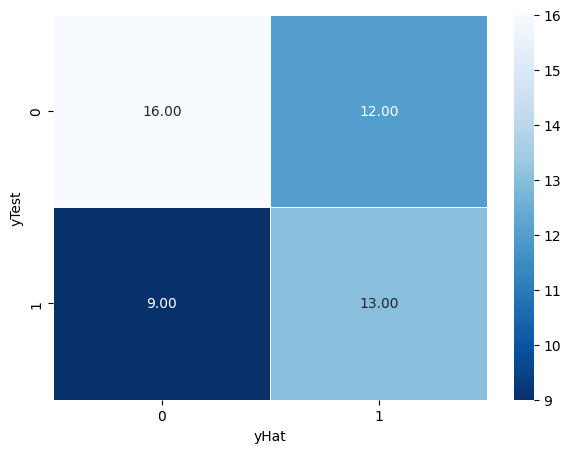

In [ ]:
# Matriz de Confusion
matriz_confusion = metrics.confusion_matrix(y_test_red, yHat_test_red)

# Graficar la matriz de Confusion
plt.figure(figsize=(7, 5))
plot_matriz = sns.heatmap(matriz_confusion, annot = True, fmt = '.2f', linewidths = 0.5, cmap = 'Blues_r')
plt.ylabel('yTest')
plt.xlabel('yHat')